# 라이브러리

In [ ]:
# 파이썬 표준 라이브러리
import random
import string
import re

# 파이썬 서드파티 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sentencepiece as spm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.utils import pad_sequences

# 클래스

## 위치 임베딩

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length: int, input_dim: int, output_dim: int, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens *= tf.math.sqrt(tf.cast(self.output_dim, tf.float32))
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, *args, **kwargs):
        return self.token_embeddings.compute_mask(*args, **kwargs)

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
            "output_dim": self.output_dim,
        })
        return config

## 인코더 레이어

In [ ]:
class EncoderLayer(layers.Layer):
    def __init__(self, embed_dim: int, dense_dim: int, num_heads: int, dropout_rate: float=0.2, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate)
        self.dense_proj = keras.Sequential(
            [layers.Dense(units=dense_dim, activation="relu"),
             layers.Dense(units=embed_dim),
             layers.Dropout(rate=dropout_rate)]
        )
        self.layernorm_1 = layers.LayerNormalization(epsilon=1e-7) # 16비트 연산을 지원하지 않는 GPU의 경우 오류가 나므로 32비트 연산으로 바꾸기 위해 설정
        self.layernorm_2 = layers.LayerNormalization(epsilon=1e-7)

    def call(self, inputs, encoder_pad_mask):
        attention_output = self.attention(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=encoder_pad_mask)
        proj_input = self.layernorm_1(layers.Add()([inputs, attention_output])) # inputs + attention_output은 mask 전파가 안됨
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(layers.Add()([proj_input, proj_output])) # proj_input + proj_outputt은 mask 전파가 안됨

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
            "dropout_rate": self.dropout_rate
        })
        return config

## 인코더

In [ ]:
class Encoder(layers.Layer):
    def __init__(self, *, num_layers, sequence_length, input_dim, embed_dim,
                 dense_dim, num_heads, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.num_layers = num_layers
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.pos_embedding = PositionalEmbedding(sequence_length=sequence_length,
                                                 input_dim=input_dim,
                                                 output_dim=embed_dim,
                                                 name="Encoder_PositionalEmbedding")
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

        self.enc_layers = [
                            EncoderLayer(embed_dim=embed_dim,
                                        dense_dim=dense_dim,
                                         num_heads=num_heads,
                                        dropout_rate=dropout_rate)
                            for _ in range(num_layers)]

    def call(self, inputs, encoder_pad_mask):
        # inputs -> Token-IDs Shape: (batch, encoder_sequence_length)
        inputs = self.pos_embedding(inputs)  # Shape: (batch_size, encoder_sequence_length, embed_dim)
        inputs = self.dropout(inputs)

        for i in range(self.num_layers):
            inputs = self.enc_layers[i](inputs=inputs, encoder_pad_mask=encoder_pad_mask)

        return inputs  # Shape: (batch_size, encoder_sequence_length, embed_dim)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_layers": self.num_layers,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
            "dropout_rate": self.dropout_rate
        })
        return config

## 디코더 레이어

In [ ]:
class DecoderLayer(layers.Layer):
    def __init__(self, embed_dim: int, dense_dim: int, num_heads: int, dropout_rate: float=0.2, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate)
        self.dense_proj = keras.Sequential([
            layers.Dense(units=dense_dim, activation="relu"),
            layers.Dense(units=embed_dim),
            layers.Dropout(rate=dropout_rate)
        ])
        self.layernorm_1 = layers.LayerNormalization(epsilon=1e-7) # 16비트 연산을 지원하지 않는 GPU의 경우 오류가 나므로 32비트 연산으로 바꾸기 위해 설정
        self.layernorm_2 = layers.LayerNormalization(epsilon=1e-7)
        self.layernorm_3 = layers.LayerNormalization(epsilon=1e-7)

    def call(self, inputs, encoder_outputs,
             encoder_pad_mask, decoder_pad_mask,
             causal_mask):
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=decoder_pad_mask & causal_mask)
        attention_output_1 = self.layernorm_1(layers.Add()([inputs, attention_output_1])) # inputs + attention_output_1는 mask 전파가 안됨
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=encoder_pad_mask
        )
        attention_output_2 = self.layernorm_2(layers.Add()([attention_output_1, attention_output_2])) # attention_output_1 + attention_output_2는 mask 전파가 안됨
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(layers.Add()([attention_output_2, proj_output])) # attention_output_2 + proj_output는 mask 전파가 안됨

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
            "dropout_rate": self.dropout_rate
        })
        return config

## 디코더

In [ ]:
class Decoder(layers.Layer):
    def __init__(self, *, num_layers, sequence_length, input_dim, embed_dim,
                 dense_dim, num_heads, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.num_layers = num_layers
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.pos_embedding = PositionalEmbedding(sequence_length=sequence_length,
                                                 input_dim=input_dim,
                                                output_dim=embed_dim,
                                                 name="Decoder_PositionalEmbedding")
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

        self.dec_layers = [
                            DecoderLayer(embed_dim=embed_dim, dense_dim=dense_dim,
                                         num_heads=num_heads, dropout_rate=dropout_rate)
                            for _ in range(num_layers)]

    def call(self, inputs, encoder_outputs,
             encoder_pad_mask, decoder_pad_mask,
             causal_mask):
        # inputs -> Token-IDs Shape: (batch, decoder_sequence_length)
        inputs = self.pos_embedding(inputs)  # Shape: (batch_size, decoder_sequence_length, embed_dim)
        inputs = self.dropout(inputs)

        for i in range(self.num_layers):
            inputs  = self.dec_layers[i](inputs=inputs, encoder_outputs=encoder_outputs,
                                         encoder_pad_mask=encoder_pad_mask, decoder_pad_mask=decoder_pad_mask,
                                         causal_mask=causal_mask)

        return inputs # Shape: (batch_size, decoder_sequence_length, embed_dim)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_layers": self.num_layers,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
            "dropout_rate": self.dropout_rate
        })
        return config

## 트랜스포머

In [ ]:
class Transformer(keras.Model):
    @staticmethod
    def pad_mask(input_ids):
        return tf.math.not_equal(input_ids, 0)[:, tf.newaxis]

    @staticmethod
    def causal_mask(decoder_sequence_length):
        return tf.linalg.band_part(tf.ones((decoder_sequence_length, decoder_sequence_length), tf.bool), -1, 0)

    def __init__(self, *, num_layers, encoder_sequence_length, decoder_sequence_length, source_vocab_size, target_vocab_size, embed_dim,
                 dense_dim, num_heads, dropout_rate):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, sequence_length=encoder_sequence_length, input_dim=source_vocab_size, embed_dim=embed_dim,
                              dense_dim=dense_dim, num_heads=num_heads, dropout_rate=dropout_rate)
        self.decoder = Decoder(num_layers=num_layers, sequence_length=decoder_sequence_length, input_dim=target_vocab_size, embed_dim=embed_dim,
                              dense_dim=dense_dim, num_heads=num_heads, dropout_rate=dropout_rate)
        self.final_layer = tf.keras.layers.Dense(units=target_vocab_size)

    def call(self, inputs):
        encoder_inputs, decoder_inputs = inputs
        encoder_pad_mask = Transformer.pad_mask(input_ids=encoder_inputs)
        decoder_pad_mask = Transformer.pad_mask(input_ids=decoder_inputs)
        causal_mask = Transformer.causal_mask(decoder_sequence_length=tf.shape(decoder_inputs)[1])

        encoder_inputs = self.encoder(inputs=encoder_inputs, encoder_pad_mask=encoder_pad_mask)  # Shape: (batch_size, encoder_sequence_length, embed_dim)
        decoder_inputs = self.decoder(inputs=decoder_inputs, encoder_outputs=encoder_inputs,
                                      encoder_pad_mask=encoder_pad_mask, decoder_pad_mask=decoder_pad_mask,
                                      causal_mask=causal_mask)  # Shape: (batch_size, decoder_sequence_length, embed_dim)

        logits = self.final_layer(decoder_inputs)  # Shape: (batch_size, decoder_sequence_length, target_vocab_size)

        try:
            # losses/metrics가 커지지 않게 keras_mask를 제거
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

## 1사이클 스케줄링

In [ ]:
class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, embed_dim, warmup_steps=4000):
        super().__init__()
        self.embed_dim = embed_dim
        self.embed_dim = tf.cast(self.embed_dim, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.embed_dim) * tf.math.minimum(arg1, arg2)

## 번역기

In [ ]:
class Translator(tf.Module):
    # 날짜 문자열 전처리 함수
    @staticmethod
    def preprocess_date(text_: re.Match) -> str:
        """날짜 문자열을 전처리 하는 함수

        Args:
            날짜 패턴 매칭은 기본적으로 mm구분자dd구분자yyyy라고 예상
            날짜 구분자는 / . - 3개
            text_: 문자열에서 패턴 매칭

        Returns
            text_: yyyy-mm-dd 형태의 날짜 문자열
        """

        text_ = text_.group()
        m, d, y = re.split(pattern=r"/|\.|-", string=text_)
        m = m.rjust(2, "0")
        d = d.rjust(2, "0")
        return f"{y}-{m}-{d}"

    # 영어 데이터 전처리 함수
    @staticmethod
    def preprocess_text(text_: str, repeat: int=2, repl_date_format: bool=False) -> str:
        """텍스트 문자열 중 일부 규칙적인 부분을 전처리 하는 함수

        Args:
            text_: 텍스트 문자열 -> str
            repeat: 연속해서 똑같이 반복되는 문자열을 감소시킬 크기 -> int
            repl_date_format: 서양식 날짜 형태를 yyyy-mm-dd 형태로 바꿀건지 여부 -> bool

        Returns:
            text_: 전처리 된 텍스트 문자열 -> str
        """

        text_ = text_.lower()
        text_ = re.sub(pattern=rf"[^\w\s{string.punctuation}]", repl=r"", string=text_)
        text_ = re.sub(pattern=r"\?+", repl=r"?", string=text_) # ?가 2번 이상 연속되면 ?로 수정
        text_ = re.sub(pattern=r"\!+", repl=r"!", string=text_) # !가 2번 이상 연속되면 !로 수정
        text_ = re.sub(pattern=r"(?P<char>\D)(?P=char){2,}", repl=r"\g<char>" * repeat, string=text_) # 숫자가 아닌 똑같은 문자열이 3번 이상 연속되면 repeat만큼으로 수정
        text_ = re.sub(pattern=r"\.{2,}", repl=r"...", string=text_) # ..을 ...으로 변경
        text_ = re.sub(pattern=r"\.\.\.(?P<s>\w)", repl=r"... \g<s>", string=text_) # 띄어쓰기 교정
        text_ = re.sub(pattern=r"\s+", repl=" ", string=text_)

        # 만약 mm구분자dd구분자yyyy형태라면 yyyy-mm-dd로 바꿀 수 있으나 날짜 포맷 종류가 너무 많아서 False로 설정
        if repl_date_format:
            text_ = re.sub(pattern=r"[0-9]{1,2}(?P<sep>/|\.|-)[0-9]{1,2}(?P=sep)[0-9]{4}", repl=Translator.preprocess_date, string=text_) # 서양식 날짜 형태를 yyyy-mm-dd로 변경

        # 영어 축약형을 풀기
        # 's 축약은 is / has 또는 아예 소유격으로 가능해서 제외
        # 'd 축약은 had / would / could 등으로 가능해서 제외
        # 'll 축약은 shall / will로 가능해서 제외
        text_ = re.sub(pattern=r"\bi'm\b", repl=r"i am", string=text_)
        text_ = re.sub(pattern=r"\b(?P<subj>you|we|they|there|who|when|where|what|how|why)'re\b", repl=r"\g<subj> are", string=text_)
        text_ = re.sub(pattern=r"\b(?P<verb>is|are|was|were|do|does|did|have|has|had|must|should|may|might|could|would|ought|dare|need)n't\b", repl=r"\g<verb> not", string=text_)
        text_ = re.sub(pattern=r"\bwon't\b", repl=r"will not", string=text_)
        text_ = re.sub(pattern=r"\bcan't\b", repl=r"can not", string=text_)
        text_ = re.sub(pattern=r"\bshan't\b", repl=r"shall not", string=text_)
        text_ = re.sub(pattern=r"\b(?P<subj>i|you|they|we|should|could|would|must|not)'ve\b", repl=r"\g<subj> have", string=text_)

        text_ = text_.strip()
        return text_

    def __init__(self, source_tokenizer, target_tokenizer, target_length, model):
        self.source_tokenizer = source_tokenizer
        self.target_tokenizer = target_tokenizer
        self.target_length = target_length
        self.model = model

    def __call__(self, sentence):
        sentence = Translator.preprocess_text(sentence)
        sentence_token = self.source_tokenizer.encode(sentence, out_type=int)
        sentence_token = tf.constant(sentence_token, dtype=tf.int32)[tf.newaxis]

        encoder_input = sentence_token

        starts = tf.constant(2, dtype=tf.int32)[tf.newaxis]
        ends = tf.constant(3, dtype=tf.int32)[tf.newaxis]
        decoder_token = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)
        decoder_token = decoder_token.write(0, starts)

        for i in tf.range(self.target_length):
            decoder_input = tf.transpose(decoder_token.stack())
            predictions = self.model.predict([encoder_input, decoder_input], verbose=0)
            predictions = predictions[0, -1, :] # 마지막 토큰으로부터 예측
            predicted_id = tf.argmax(input=predictions, output_type=tf.int32)[tf.newaxis]

            if predicted_id == ends:
                break

            decoder_token = decoder_token.write(i + 1, predicted_id)

        decoder_token = tf.transpose(decoder_token.stack())[0]
        decoder_token = decoder_token[1:]
        decoder_token = decoder_token.numpy().tolist()

        return self.target_tokenizer.DecodeIds(decoder_token)

In [ ]:
class ExportTranslator(tf.Module):
    def __init__(self, translator):
        self.translator = translator

    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def __call__(self, sentence):
        result = self.translator(sentence)

        return result

# 함수

In [ ]:
def make_sentencepiece(name: str, vocab_size: int) -> spm.SentencePieceProcessor:
    """말뭉치를 sentencepiece로 학습시켜 반납하는 함수

    Args:
        name: 어떤 언어 말뭉치를 학습시킬지 입력하는 문자열 -> str
        vocab_size: 어휘 크기

    Return:
        sentencepiece
    """
    assert vocab_size > 0

    corpus_path = f"/content/drive/MyDrive/Practice/Natural_Language/kor-eng/{name}_corpus.txt"
    prefix = f"tf-sp-bpe-{name}-nlp"
    if name == "eng":
        byte_fallback = " --byte_fallback=true"
    else:
        byte_fallback = ""
    spm.SentencePieceTrainer.train(
        f"--input={corpus_path} --model_prefix={prefix} --vocab_size={vocab_size}" +
        " --model_type=bpe" +
        " --max_sentence_length=9999" + # 문장 최대 길이 -> 이게 너무 길면 에러발생
        " --pad_id=0 --pad_piece=<PAD>" + # pad (0)
        " --unk_id=1 --unk_piece=<UNK>" + # unknown (1)
        " --bos_id=2 --bos_piece=<s>" + # begin of sequence (2)
        " --eos_id=3 --eos_piece=</s>" + # end of sequence (3)
        f"{byte_fallback}" + # add byte_fallback for unk tokens
        " --add_dummy_prefix=false" + # dummy_prefix(_) out
        " --user_defined_symbols=<s>,</s>,<sep>,<cls>,<mask>") # 사용자 정의 토큰

    sp = spm.SentencePieceProcessor()
    spm_path = f"/content/{prefix}.model"
    sp.load(spm_path)
    return sp

In [ ]:
# 데이터셋 포맷 함수
def format_dataset(source: tf.Tensor, target: tf.Tensor) -> tuple[tuple[tf.Tensor, tf.Tensor], tf.Tensor]:
    """데이터셋 포맷을 fit 형태로 바꾸는 함수

    Args:
        source: 소스 데이터 텐서 -> tf.Tensor
        target: 타겟 데이터 텐서 -> tf.Tensor

    Returns:
        ((tf.Tensor, tf.Tensor), tf.Tensor)
    """
    return ((source, target[:, :-1]), target[:, 1:])

# 리스트로 tf.data.Dataset 생성 함수
def tf_dataset(source: list[list[int]], target: list[list[int]], batch_size: int) -> tf.data.Dataset:
    """2차원 리스트를 tf.data.Dataset으로 만드는 함수

    Args:
        source: 숫자로 인코딩된 소스 데이터 2차원 리스트 -> list[list[int]]
        target: 숫자로 인코딩된 타겟 데이터 2차원 리스트 -> list[list[int]]
        batch_size: 배치 크기 -> int

    Returns:
        tf.data.Dataset
    """
    dataset = tf.data.Dataset.from_tensor_slices((source, target)).shuffle(len(source))
    dataset = dataset.batch(batch_size).map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE).cache()
    return dataset

# train/validation 생성 함수
def make_dataset(dataset: pd.DataFrame,
                 source_lang: str, target_lang: str,
                 source_sequence_length: int, target_sequence_length: int,
                rate: float=0.9, batch_size: int=32) -> tuple[tf.data.Dataset, tf.data.Dataset]:
    """훈련/검증 데이터를 생성하는 함수

    Args:
        dataset: 숫자로 인코딩된 소스와 타겟 데이터프레임 -> pd.DataFrame
        source_lang: 소스 데이터 언어 -> str
        target_lang: 타겟 데이터 언어 -> str
        source_sequence_length: 인코딩된 소스 데이터 문장 길이 -> int
        target_sequence_length: 인코딩된 타겟 데이터 문장 길이 -> int
        rate: 전체 데이터 중 학습 데이터의 비율 -> float(0 <= rate <= 1)
        batch_size: 배치 크기 -> int

    Returns:
        (train 데이터셋, valid 데이터셋)
        (tf.data.Dataset tf.data.Dataset)
    """
    assert source_sequence_length > 0 and target_sequence_length > 0
    assert 0 <= rate <= 1
    assert batch_size > 0

    # 데이터프레임을 무작위로 섞기
    dataset_copy = dataset.copy(deep=True)
    shuffle_list = list(range(len(dataset_copy)))
    np.random.shuffle(shuffle_list)
    dataset_copy = dataset_copy.iloc[shuffle_list, :].reset_index(drop=True)

    # 소스 및 타겟 데이터를 제로 패딩 -> 타겟 데이터는 다음 스텝 훈련을 위해 target_sequence_length + 1의 길이로 패딩
    dataset_copy[source_lang] = dataset_copy[source_lang].map(lambda x: pad_sequences(sequences=[x], maxlen=source_sequence_length,
                                                                                      padding="post", truncating="post")[0].tolist())
    dataset_copy[target_lang] = dataset_copy[target_lang].map(lambda x: pad_sequences(sequences=[x], maxlen=target_sequence_length + 1,
                                                                                      padding="post", truncating="post")[0].tolist())

    # train과 valid로 분할
    n = int(len(dataset_copy) * rate)
    train_source, train_target = dataset_copy.iloc[:n, 0].to_list(), dataset_copy.iloc[:n, 1].to_list()
    valid_source, valid_target = dataset_copy.iloc[n:, 0].to_list(), dataset_copy.iloc[n:, 1].to_list()
    # 데이터셋 생성
    train_dataset = tf_dataset(source=train_source, target=train_target, batch_size=batch_size)
    valid_dataset = tf_dataset(source=valid_source, target=valid_target, batch_size=batch_size)
    return train_dataset, valid_dataset

In [ ]:
# 마스킹된 손실함수
def masked_loss(label: tf.Tensor, pred: tf.Tensor) -> tf.Tensor:
    """마스킹을 포함한 예측값과 실제값의 손실값을 계산하는 함수

    Args:
        label: 실제값 -> tf.Tensor
        pred: 예측값 -> tf.Tensor

    Returns:
        손실값 -> tf.Tensor
    """
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(y_true=label, y_pred=pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(input_tensor=loss) / tf.reduce_sum(input_tensor=mask)
    return loss

# 마스킹된 정확도 함수
def masked_accuracy(label: tf.Tensor, pred: tf.Tensor) -> tf.Tensor:
    """마스킹을 포함한 예측값과 실제값의 정확도를 계산하는 함수

    Args:
        label: 실제값 -> tf.Tensor
        pred: 예측값 -> tf.Tensor

    Returns:
        정확도 -> tf.Tensor
    """
    pred = tf.argmax(input=pred, axis=2)
    label = tf.cast(label, dtype=pred.dtype)
    matched = label == pred

    mask = label != 0

    matched = matched & mask

    matched = tf.cast(matched, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(input_tensor=matched) / tf.reduce_sum(input_tensor=mask)

# 변수

In [ ]:
SEED = 1234
tf.random.set_seed(SEED)

source_lang = "English"
target_lang = "Korean"

# 데이터 불러오기

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Practice/Natural_Language/kor-eng/kor.txt',
                 sep="\t",
                 header=None,
                 usecols=[0, 1],
                 names=[source_lang, target_lang],
                 dtype="string")

In [ ]:
df = df.map(lambda x: Translator.preprocess_text(text_=x))
df[target_lang] = df[target_lang].map(lambda x: f"<s> {x} </s>") # 시작 토큰(<s>) 및 종료 토큰(</s>) 추가

# Sentencepiece 토크나이저

In [ ]:
df[source_lang].to_csv("/content/drive/MyDrive/Practice/Natural_Language/kor-eng/eng_corpus.txt", sep="\t", header=False, index=False)
df[target_lang].to_csv("/content/drive/MyDrive/Practice/Natural_Language/kor-eng/kor_corpus.txt", sep="\t", header=False, index=False)

In [ ]:
source_vocab_size = 3000
target_vocab_size = 3000
source_sp = make_sentencepiece(name="eng", vocab_size=source_vocab_size)
target_sp = make_sentencepiece(name="kor", vocab_size=target_vocab_size)

In [ ]:
df_encode = df.apply(lambda x: source_sp.encode(x.tolist(), out_type=int) if x.name == source_lang
                          else target_sp.encode(x.tolist(), out_type=int))

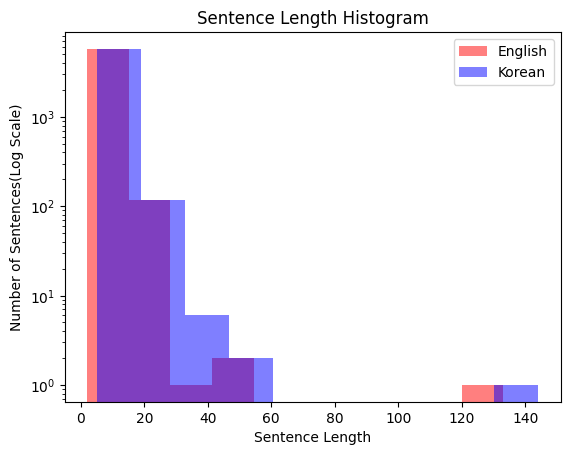

In [ ]:
# 인코딩된 길이 시각화
plt.hist(x=df_encode[source_lang].map(len), label=source_lang, alpha=0.5, color="r")
plt.hist(x=df_encode[target_lang].map(len), label=target_lang, alpha=0.5, color="b")
plt.title("Sentence Length Histogram")
plt.xlabel("Sentence Length")
plt.ylabel("Number of Sentences(Log Scale)")
plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
df_encode.map(len).max()

English    133
Korean     144
dtype: int64

In [ ]:
source_sequence_length = 20
target_sequence_length = 20
print(f"Number of {source_lang} Length greanter than {source_sequence_length}: {(df_encode[source_lang].map(len) > source_sequence_length).sum()}")
print(f"Number of {target_lang} Length greanter than {target_sequence_length}: {(df_encode[target_lang].map(len) > target_sequence_length).sum()}")

Number of English Length greanter than 20: 25
Number of Korean Length greanter than 20: 62


# 모델

## 데이터셋 생성

In [ ]:
rate = 0.9
batch_size = 32

train_dataset, valid_dataset = make_dataset(dataset=df_encode,
                                            source_lang=source_lang,
                                            target_lang=target_lang,
                                            source_sequence_length=source_sequence_length,
                                            target_sequence_length=target_sequence_length,
                                            rate=rate,
                                            batch_size=batch_size)

In [ ]:
for (sou, tar0), tar1 in train_dataset.take(1):
    print(sou.shape)
    print(tar0.shape)
    print(tar1.shape)

(32, 20)
(32, 20)
(32, 20)


In [ ]:
for (sou, tar0), tar1 in train_dataset.take(1):
    print(tar0[0])
    print(tar1[0])

tf.Tensor(
[   2  190   79 1584  131  881 2056 2737   27   17 2057 2056    3    0
    0    0    0    0    0    0], shape=(20,), dtype=int32)
tf.Tensor(
[ 190   79 1584  131  881 2056 2737   27   17 2057 2056    3    0    0
    0    0    0    0    0    0], shape=(20,), dtype=int32)


## 모델 아키텍처

In [ ]:
num_layers = 2
embed_dim = 256
dense_dim = 1024
num_heads = 8
dropout_rate = 0.1

model = Transformer(num_layers=num_layers, encoder_sequence_length=source_sequence_length, decoder_sequence_length=target_sequence_length,
                    source_vocab_size=source_vocab_size, target_vocab_size=target_vocab_size, embed_dim=embed_dim,
                 dense_dim=dense_dim, num_heads=num_heads, dropout_rate=dropout_rate)

## 모델 훈련

### 컴파일 옵션

In [ ]:
learning_rate = CustomSchedule(embed_dim=embed_dim)
optimizer = tf.keras.optimizers.Nadam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

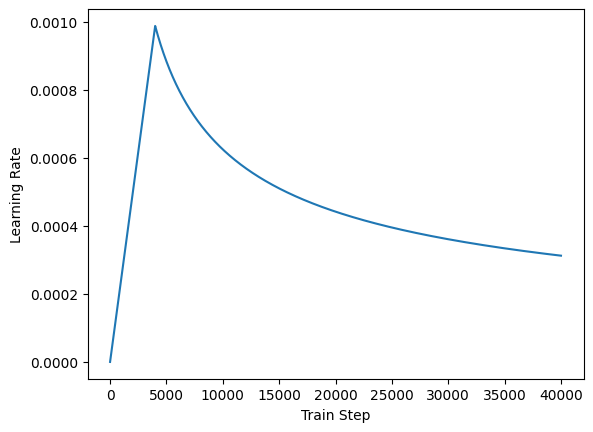

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

In [ ]:
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])

### 훈련

In [ ]:
callbacks_list = [EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                patience=3, restore_best_weights=True),
                  TensorBoard(log_dir="/full_path_to_your_log_dir")]

history = model.fit(train_dataset, epochs=50, shuffle=True, validation_data=valid_dataset, callbacks=callbacks_list)

Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 54s 143ms/step - loss: 7.5485 - masked_accuracy: 0.1161 - val_loss: 5.9607 - val_masked_accuracy: 0.3067
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 5.6839 - masked_accuracy: 0.3163 - val_loss: 5.0715 - val_masked_accuracy: 0.3335
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 4.8836 - masked_accuracy: 0.3432 - val_loss: 4.6768 - val_masked_accuracy: 0.3571
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 4.4446 - masked_accuracy: 0.3707 - val_loss: 4.3952 - val_masked_accuracy: 0.3772
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 4.0202 - masked_accuracy: 0.4026 - val_loss: 4.1348 - val_masked_accuracy: 0.3965
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 3.5678 - masked_accuracy: 0.4424 - val_loss: 3.8995 - val_masked_accuracy: 0.4175
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 3.0990 - masked_accuracy: 0.4924 - val_loss: 3.6976 - val_masked_accuracy: 0.

In [ ]:
model.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Encoder)                    │ ?                           │       6,033,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Decoder)                    │ ?                           │      10,241,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 20, 3000)            │         771,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,137,834 (195.08 MB)

 Trainable params: 17,045,944 (65.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,091,890 (130.05 MB)

# 번역

In [ ]:
translator = Translator(source_tokenizer=source_sp, target_tokenizer=target_sp,
                        target_length=target_sequence_length, model=model)

In [ ]:
nums = list(range(len(df)))

for _ in range(10):
    print('-' * 20)
    n = random.choice(nums)
    random_text = df[source_lang][n]
    target_translate = translator(random_text)
    real_text = df[target_lang][n]
    print(f"{source_lang}: {random_text}")
    print(f"Translated {target_lang}: {target_translate}")
    print(f"Real {target_lang}: {real_text}")
    print('-' * 20)

--------------------
English: a lot of snow fell last year.
Translated Korean: 작년에 눈이 엄청 내렸어. 
Real Korean: <s> 작년에 눈이 엄청 내렸어. </s>
--------------------
--------------------
English: i do not buy it.
Translated Korean: 내가 그걸 안 드릴 수 없어. 
Real Korean: <s> 못 믿어. </s>
--------------------
--------------------
English: take care.
Translated Korean: 주의하세요. 
Real Korean: <s> 주의하세요. </s>
--------------------
--------------------
English: she is not married.
Translated Korean: 그 사람은 미혼이에요. 
Real Korean: <s> 그는 결혼하지 않았다. </s>
--------------------
--------------------
English: i have a terrible headache.
Translated Korean: 내가 가져가 있다. 
Real Korean: <s> 나는 두통이 심하다. </s>
--------------------
--------------------
English: are you able to swim?
Translated Korean: 수영하는 것이 잘 말해? 
Real Korean: <s> 수영하실 수 있나요? </s>
--------------------
--------------------
English: tom really is a nice person, is not he?
Translated Korean: 톰은 정말 좋은 사람이지? 
Real Korean: <s> 톰은 정말 좋은 사람이지? </s>
--------------------
---------